# Task 2: SVM人脸识别与拒识系统

本notebook实现基于SVM的人脸识别系统，采用阈值法构建拒识系统。

## 主要内容
1. 加载预处理后的Yale数据集特征
2. 按人物ID分层划分训练集/验证集/测试集
3. 训练SVM分类器
4. 构建基于阈值的拒识系统
5. 在已知类测试集上评估性能
6. 加载ORL外部数据集作为未知类
7. 在混合测试集上评估拒识性能

In [1]:
import numpy as np
import pickle
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage.transform import resize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("库加载完成!")

D:\Anaconda\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
D:\Anaconda\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


库加载完成!


## 1. 加载预处理后的Yale数据

In [2]:
# 加载预处理后的Yale数据
data = np.load('preprocessed_data/yale_preprocessed.npz', allow_pickle=True)

print("数据键:", list(data.keys()))

# 提取特征和标签
X_yale = data['combined_features']  # 组合特征 (165, 4416)
y_yale = data['labels']  # 标签 (165,)

print(f"\nYale数据集:")
print(f"  特征维度: {X_yale.shape}")
print(f"  标签维度: {y_yale.shape}")
print(f"  类别数量: {len(np.unique(y_yale))}")
print(f"  每个类别样本数: {np.bincount(y_yale.astype(int))}")

数据键: ['images', 'labels', 'pca_features', 'lbp_features', 'hog_features', 'combined_features']

Yale数据集:
  特征维度: (165, 4416)
  标签维度: (165,)
  类别数量: 15
  每个类别样本数: [ 0 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]


## 2. 数据集分层划分

按照人物ID进行分层划分，确保:
- 训练集: 60%
- 验证集: 20%  
- 测试集: 20%
- 每个人物在各集合中都有样本

In [3]:
# 标签编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_yale)

# 第一次划分: 80% 训练+验证, 20% 测试
X_train_val, X_test_known, y_train_val, y_test_known = train_test_split(
    X_yale, y_encoded, 
    test_size=0.2, 
    stratify=y_encoded,
    random_state=42
)

# 第二次划分: 75% 训练, 25% 验证 (总体 60% 训练, 20% 验证)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,
    stratify=y_train_val,
    random_state=42
)

print("数据集划分结果:")
print(f"  训练集: {X_train.shape[0]} 样本 ({X_train.shape[0]/len(X_yale)*100:.1f}%)")
print(f"  验证集: {X_val.shape[0]} 样本 ({X_val.shape[0]/len(X_yale)*100:.1f}%)")
print(f"  测试集: {X_test_known.shape[0]} 样本 ({X_test_known.shape[0]/len(X_yale)*100:.1f}%)")

print(f"\n训练集类别分布: {np.bincount(y_train)}")
print(f"验证集类别分布: {np.bincount(y_val)}")
print(f"测试集类别分布: {np.bincount(y_test_known)}")

# 验证每个类别在所有集合中都出现
print(f"\n训练集类别数: {len(np.unique(y_train))}")
print(f"验证集类别数: {len(np.unique(y_val))}")
print(f"测试集类别数: {len(np.unique(y_test_known))}")

数据集划分结果:
  训练集: 99 样本 (60.0%)
  验证集: 33 样本 (20.0%)
  测试集: 33 样本 (20.0%)

训练集类别分布: [7 7 7 6 6 7 6 7 6 6 7 7 6 7 7]
验证集类别分布: [2 2 2 2 3 2 2 2 3 3 2 2 2 2 2]
测试集类别分布: [2 2 2 3 2 2 3 2 2 2 2 2 3 2 2]

训练集类别数: 15
验证集类别数: 15
测试集类别数: 15


## 3. 特征标准化

In [4]:
# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_known_scaled = scaler.transform(X_test_known)

print(f"特征标准化完成")
print(f"训练集特征均值范围: [{X_train_scaled.mean(axis=0).min():.4f}, {X_train_scaled.mean(axis=0).max():.4f}]")
print(f"训练集特征标准差范围: [{X_train_scaled.std(axis=0).min():.4f}, {X_train_scaled.std(axis=0).max():.4f}]")

特征标准化完成
训练集特征均值范围: [-0.0000, 0.0000]
训练集特征标准差范围: [1.0000, 1.0000]


## 4. SVM模型训练与网格搜索

In [5]:
# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

# 创建SVM分类器 (启用概率估计和决策函数)
svm_base = SVC(probability=True, decision_function_shape='ovr', random_state=42)

# 网格搜索
print("开始网格搜索...")
grid_search = GridSearchCV(
    svm_base, 
    param_grid, 
    cv=3,  # 3折交叉验证
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n最优参数: {grid_search.best_params_}")
print(f"最优交叉验证准确率: {grid_search.best_score_:.4f}")

开始网格搜索...
Fitting 3 folds for each of 40 candidates, totalling 120 fits

最优参数: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
最优交叉验证准确率: 0.8586


In [6]:
# 使用最优参数训练最终模型
svm_model = grid_search.best_estimator_

# 在验证集上评估
y_val_pred = svm_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"验证集准确率: {val_accuracy:.4f}")

验证集准确率: 0.9091


## 5. 已知类测试集评估

In [7]:
# 在已知类测试集上预测
y_test_pred = svm_model.predict(X_test_known_scaled)

# 计算评估指标
accuracy = accuracy_score(y_test_known, y_test_pred)
precision = precision_score(y_test_known, y_test_pred, average='weighted')
recall = recall_score(y_test_known, y_test_pred, average='weighted')
f1 = f1_score(y_test_known, y_test_pred, average='weighted')

print("=" * 50)
print("已知类测试集评估结果")
print("=" * 50)
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision, weighted): {precision:.4f}")
print(f"召回率 (Recall, weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

已知类测试集评估结果
准确率 (Accuracy): 0.7879
精确率 (Precision, weighted): 0.8157
召回率 (Recall, weighted): 0.7879
F1-score (weighted): 0.7830


In [8]:
# 详细分类报告
class_names = [f"Subject {i+1}" for i in range(len(label_encoder.classes_))]
print("\n分类报告:")
print(classification_report(y_test_known, y_test_pred, target_names=class_names))


分类报告:
              precision    recall  f1-score   support

   Subject 1       1.00      1.00      1.00         2
   Subject 2       0.67      1.00      0.80         2
   Subject 3       0.67      1.00      0.80         2
   Subject 4       0.67      0.67      0.67         3
   Subject 5       1.00      1.00      1.00         2
   Subject 6       0.50      0.50      0.50         2
   Subject 7       0.75      1.00      0.86         3
   Subject 8       1.00      1.00      1.00         2
   Subject 9       1.00      0.50      0.67         2
  Subject 10       1.00      1.00      1.00         2
  Subject 11       1.00      1.00      1.00         2
  Subject 12       1.00      0.50      0.67         2
  Subject 13       1.00      0.67      0.80         3
  Subject 14       0.50      0.50      0.50         2
  Subject 15       0.50      0.50      0.50         2

    accuracy                           0.79        33
   macro avg       0.82      0.79      0.78        33
weighted avg       

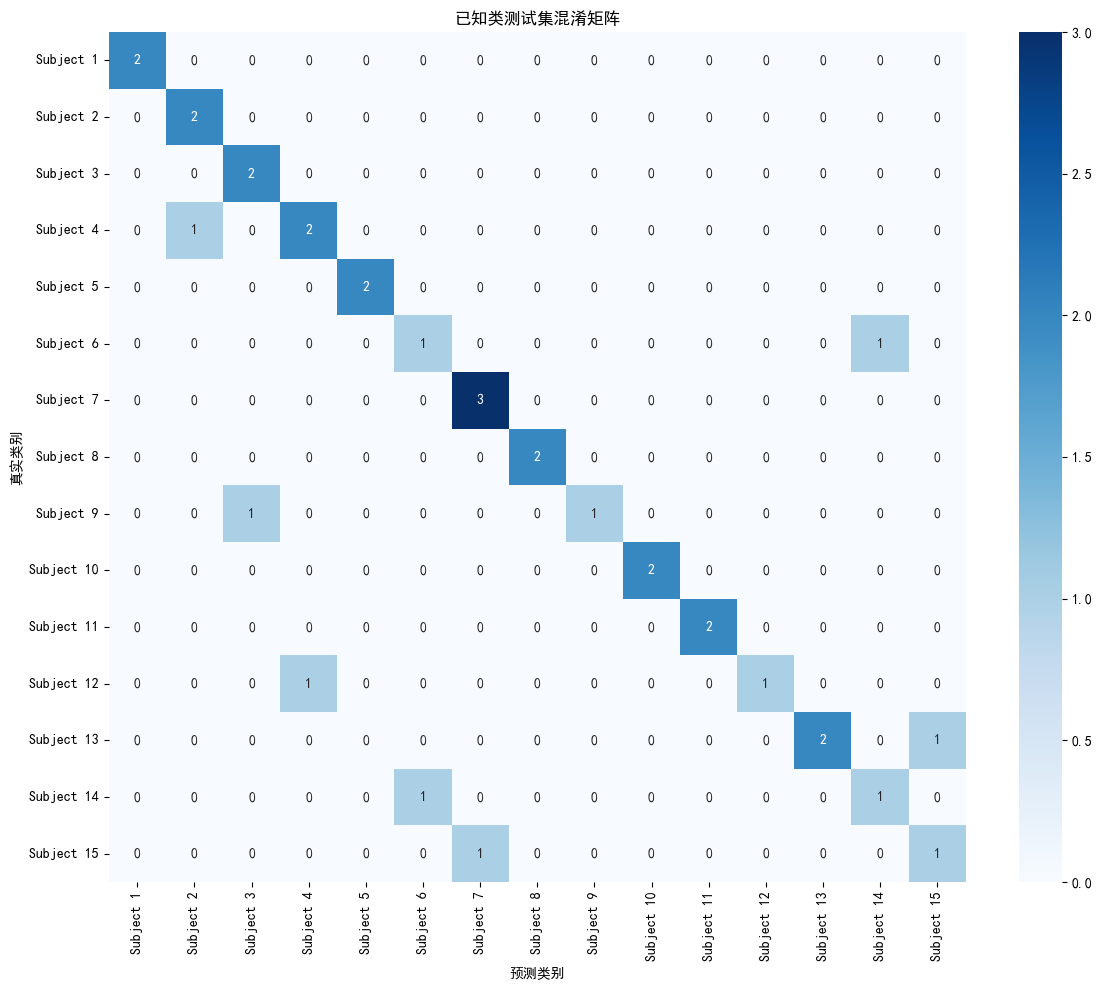

混淆矩阵已保存为 confusion_matrix_known.png


In [9]:
# 绘制混淆矩阵
cm = confusion_matrix(y_test_known, y_test_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.title('已知类测试集混淆矩阵')
plt.tight_layout()
plt.savefig('confusion_matrix_known.png', dpi=150)
plt.show()

print("混淆矩阵已保存为 confusion_matrix_known.png")

## 6. 加载ORL外部数据集

In [10]:
# 加载预处理器
with open('preprocessed_data/preprocessors.pkl', 'rb') as f:
    preprocessors = pickle.load(f)

print("预处理器内容:", list(preprocessors.keys()))

预处理器内容: ['pca', 'scaler', 'scaler_pca', 'scaler_lbp', 'scaler_hog']


In [11]:
def load_and_preprocess_orl(orl_path, target_size=(243, 320)):
    """
    加载并预处理ORL数据集
    ORL图像原始大小为 92x112，需要resize到与Yale一致
    """
    images = []
    labels = []
    
    # 遍历所有subject文件夹
    for subject_dir in sorted(os.listdir(orl_path)):
        subject_path = os.path.join(orl_path, subject_dir)
        if not os.path.isdir(subject_path):
            continue
        
        subject_id = int(subject_dir[1:])  # 从 's1' 提取 1
        
        for img_file in sorted(os.listdir(subject_path)):
            if img_file.endswith('.pgm'):
                img_path = os.path.join(subject_path, img_file)
                img = Image.open(img_path)
                
                # Resize到目标大小
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                img_array = np.array(img_resized, dtype=np.float64)
                
                # 归一化到 [0, 1]
                img_array = img_array / 255.0
                
                images.append(img_array)
                labels.append(subject_id)
    
    return np.array(images), np.array(labels)

# 加载ORL数据
orl_path = 'datasets/orl_data'
X_orl_images, y_orl = load_and_preprocess_orl(orl_path)

print(f"ORL数据集:")
print(f"  图像数量: {X_orl_images.shape[0]}")
print(f"  图像尺寸: {X_orl_images.shape[1:]}")
print(f"  类别数量: {len(np.unique(y_orl))}")

ORL数据集:
  图像数量: 400
  图像尺寸: (320, 243)
  类别数量: 40


In [12]:
def extract_features_from_images(images, preprocessors):
    """
    使用与Yale相同的预处理器提取特征
    """
    all_features = []
    
    for img in images:
        features = []
        
        # 1. HOG特征
        hog_features = hog(
            img,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            feature_vector=True
        )
        features.append(hog_features)
        
        # 2. LBP特征
        lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10), density=True)
        features.append(lbp_hist)
        
        # 3. Gabor特征
        gabor_features = []
        for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
            for frequency in [0.1, 0.2, 0.3]:
                filt_real, filt_imag = gabor(img, frequency=frequency, theta=theta)
                gabor_features.extend([filt_real.mean(), filt_real.std(),
                                       filt_imag.mean(), filt_imag.std()])
        features.append(np.array(gabor_features))
        
        # 4. 像素特征 (降采样)
        img_small = resize(img, (32, 32), anti_aliasing=True)
        pixel_features = img_small.flatten()
        features.append(pixel_features)
        
        # 合并所有特征
        combined = np.concatenate(features)
        all_features.append(combined)
    
    return np.array(all_features)

print("提取ORL特征中...")
X_orl_features = extract_features_from_images(X_orl_images, preprocessors)
print(f"ORL特征维度: {X_orl_features.shape}")

提取ORL特征中...
ORL特征维度: (400, 10658)


In [13]:
# 确保ORL特征维度与Yale一致
# 如果维度不同，进行调整
yale_dim = X_train_scaled.shape[1]
orl_dim = X_orl_features.shape[1]

print(f"Yale特征维度: {yale_dim}")
print(f"ORL特征维度: {orl_dim}")

if orl_dim != yale_dim:
    print(f"\n特征维度不匹配，进行调整...")
    if orl_dim > yale_dim:
        # 截断
        X_orl_features = X_orl_features[:, :yale_dim]
    else:
        # 填充零
        padding = np.zeros((X_orl_features.shape[0], yale_dim - orl_dim))
        X_orl_features = np.hstack([X_orl_features, padding])
    print(f"调整后ORL特征维度: {X_orl_features.shape}")

# 使用相同的scaler标准化
X_orl_scaled = scaler.transform(X_orl_features)
print(f"ORL特征标准化完成")

Yale特征维度: 4416
ORL特征维度: 10658

特征维度不匹配，进行调整...
调整后ORL特征维度: (400, 4416)
ORL特征标准化完成


## 7. 阈值法构建拒识系统

In [14]:
def get_confidence_scores(model, X):
    """
    获取SVM的置信度分数
    使用decision_function的最大值作为置信度
    """
    decision_values = model.decision_function(X)
    if len(decision_values.shape) == 1:
        # 二分类情况
        confidence = np.abs(decision_values)
    else:
        # 多分类情况 - 使用最大决策值
        confidence = decision_values.max(axis=1)
    return confidence

# 计算验证集和训练集的置信度分数
train_confidence = get_confidence_scores(svm_model, X_train_scaled)
val_confidence = get_confidence_scores(svm_model, X_val_scaled)

print(f"训练集置信度范围: [{train_confidence.min():.4f}, {train_confidence.max():.4f}]")
print(f"验证集置信度范围: [{val_confidence.min():.4f}, {val_confidence.max():.4f}]")

训练集置信度范围: [14.3111, 14.3124]
验证集置信度范围: [13.2641, 14.3113]


In [15]:
# 使用验证集确定最优阈值
# 方法：找到能够正确分类验证集样本的最小置信度

# 获取验证集预测
y_val_pred = svm_model.predict(X_val_scaled)
correct_mask = (y_val_pred == y_val)

# 正确分类样本的置信度
correct_confidence = val_confidence[correct_mask]
incorrect_confidence = val_confidence[~correct_mask]

print(f"正确分类样本数: {correct_mask.sum()}")
print(f"错误分类样本数: {(~correct_mask).sum()}")
if len(correct_confidence) > 0:
    print(f"正确分类置信度范围: [{correct_confidence.min():.4f}, {correct_confidence.max():.4f}]")

# 设置阈值为正确分类样本的最小置信度的某个百分位数
# 这样可以接受大部分已知类样本
threshold_percentile = 5  # 使用第5百分位数
if len(correct_confidence) > 0:
    rejection_threshold = np.percentile(correct_confidence, threshold_percentile)
else:
    rejection_threshold = np.percentile(val_confidence, threshold_percentile)
print(f"\n拒识阈值 (第{threshold_percentile}百分位): {rejection_threshold:.4f}")

正确分类样本数: 30
错误分类样本数: 3
正确分类置信度范围: [14.2603, 14.3113]

拒识阈值 (第5百分位): 14.2955


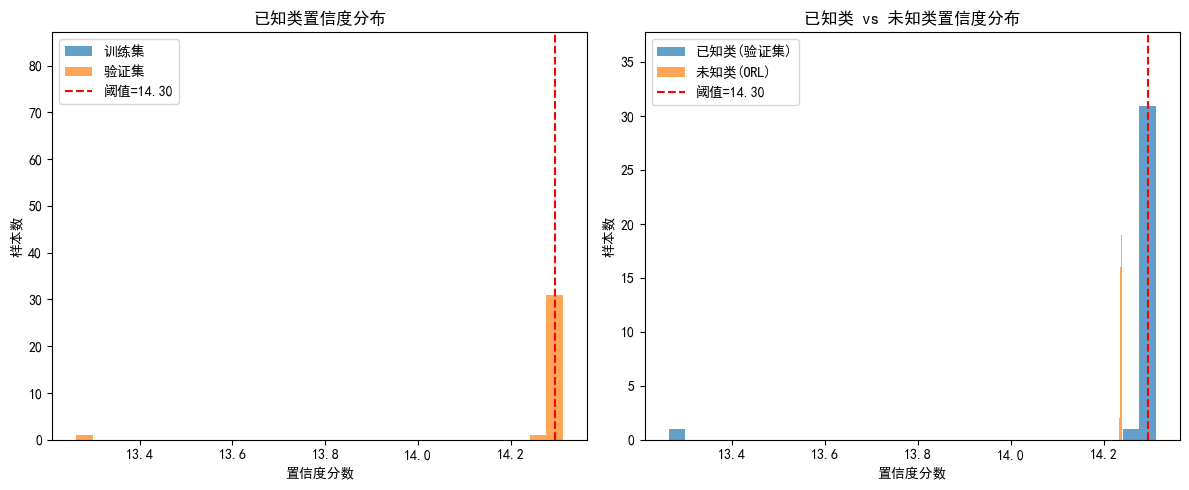

In [16]:
# 可视化置信度分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_confidence, bins=30, alpha=0.7, label='训练集')
plt.hist(val_confidence, bins=30, alpha=0.7, label='验证集')
plt.axvline(x=rejection_threshold, color='r', linestyle='--', label=f'阈值={rejection_threshold:.2f}')
plt.xlabel('置信度分数')
plt.ylabel('样本数')
plt.title('已知类置信度分布')
plt.legend()

plt.subplot(1, 2, 2)
# 计算ORL的置信度
orl_confidence = get_confidence_scores(svm_model, X_orl_scaled)
plt.hist(val_confidence, bins=30, alpha=0.7, label='已知类(验证集)')
plt.hist(orl_confidence, bins=30, alpha=0.7, label='未知类(ORL)')
plt.axvline(x=rejection_threshold, color='r', linestyle='--', label=f'阈值={rejection_threshold:.2f}')
plt.xlabel('置信度分数')
plt.ylabel('样本数')
plt.title('已知类 vs 未知类置信度分布')
plt.legend()

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150)
plt.show()

## 8. 混合测试集评估

In [17]:
def evaluate_with_rejection(model, X_known, y_known, X_unknown, threshold):
    """
    使用阈值法评估拒识系统
    
    Parameters:
    -----------
    model: 训练好的SVM模型
    X_known: 已知类测试样本
    y_known: 已知类真实标签
    X_unknown: 未知类样本 (ORL)
    threshold: 拒识阈值
    
    Returns:
    --------
    known_recall: 已知类召回率 (正确接受已知样本的比例)
    unknown_rejection_rate: 未知类拒绝率 (正确拒绝未知样本的比例)
    """
    # 获取置信度分数
    known_confidence = get_confidence_scores(model, X_known)
    unknown_confidence = get_confidence_scores(model, X_unknown)
    
    # 已知类: 置信度 >= 阈值 => 接受
    known_accepted = known_confidence >= threshold
    
    # 对于接受的已知类样本，还需要预测正确
    y_known_pred = model.predict(X_known)
    known_correct = (y_known_pred == y_known) & known_accepted
    
    # 已知类召回率: 正确接受且正确分类的比例
    # 或者更宽松: 只要接受就算
    known_recall = known_accepted.sum() / len(known_confidence)
    
    # 未知类: 置信度 < 阈值 => 拒绝 (正确行为)
    unknown_rejected = unknown_confidence < threshold
    unknown_rejection_rate = unknown_rejected.sum() / len(unknown_confidence)
    
    return known_recall, unknown_rejection_rate, known_confidence, unknown_confidence

# 评估
known_recall, unknown_rejection, known_conf, unknown_conf = evaluate_with_rejection(
    svm_model, X_test_known_scaled, y_test_known, X_orl_scaled, rejection_threshold
)

print("=" * 50)
print("混合测试集评估结果 (阈值法拒识)")
print("=" * 50)
print(f"拒识阈值: {rejection_threshold:.4f}")
print(f"\n已知类召回率: {known_recall:.4f}")
print(f"  (系统正确接受已知类样本的比例)")
print(f"\n未知类拒绝率: {unknown_rejection:.4f}")
print(f"  (系统正确拒绝未知类样本的比例)")

混合测试集评估结果 (阈值法拒识)
拒识阈值: 14.2955

已知类召回率: 0.7879
  (系统正确接受已知类样本的比例)

未知类拒绝率: 1.0000
  (系统正确拒绝未知类样本的比例)


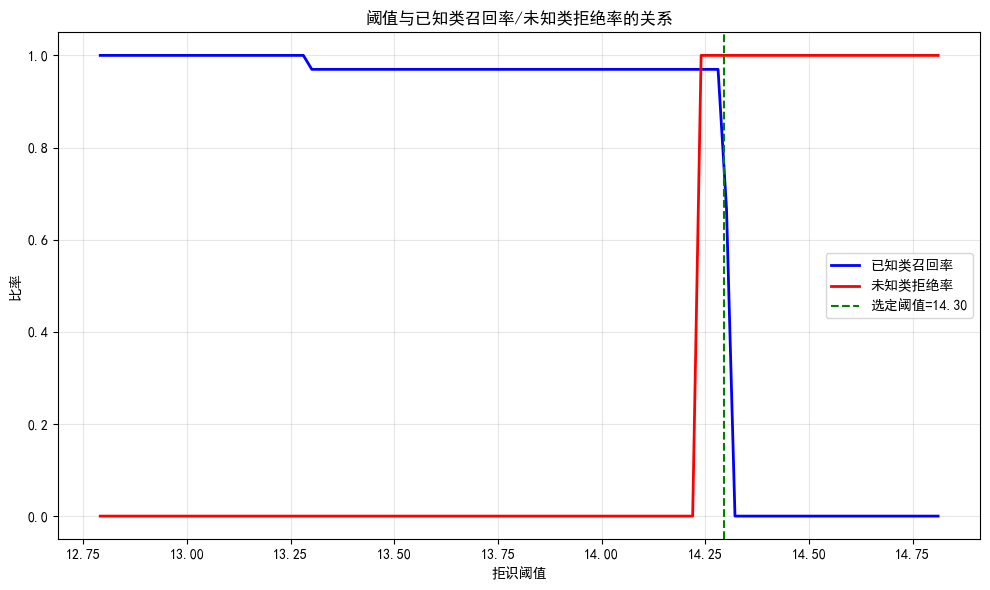

In [18]:
# 尝试不同阈值
thresholds = np.linspace(known_conf.min()-0.5, known_conf.max()+0.5, 100)
known_recalls = []
unknown_rejections = []

for t in thresholds:
    kr = (known_conf >= t).sum() / len(known_conf)
    ur = (unknown_conf < t).sum() / len(unknown_conf)
    known_recalls.append(kr)
    unknown_rejections.append(ur)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, known_recalls, 'b-', label='已知类召回率', linewidth=2)
plt.plot(thresholds, unknown_rejections, 'r-', label='未知类拒绝率', linewidth=2)
plt.axvline(x=rejection_threshold, color='g', linestyle='--', 
            label=f'选定阈值={rejection_threshold:.2f}')
plt.xlabel('拒识阈值')
plt.ylabel('比率')
plt.title('阈值与已知类召回率/未知类拒绝率的关系')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_tradeoff.png', dpi=150)
plt.show()

## 9. ROC曲线与AUC值

In [19]:
# 构建二分类问题: 已知类 vs 未知类
# 正例: 已知类 (label=1)
# 负例: 未知类 (label=0)

# 合并置信度分数
all_confidence = np.concatenate([known_conf, unknown_conf])

# 创建真实标签: 1=已知类, 0=未知类
y_true_binary = np.concatenate([np.ones(len(known_conf)), np.zeros(len(unknown_conf))])

# 计算ROC曲线
fpr, tpr, roc_thresholds = roc_curve(y_true_binary, all_confidence)
roc_auc = auc(fpr, tpr)

print(f"AUC值: {roc_auc:.4f}")

AUC值: 0.9697


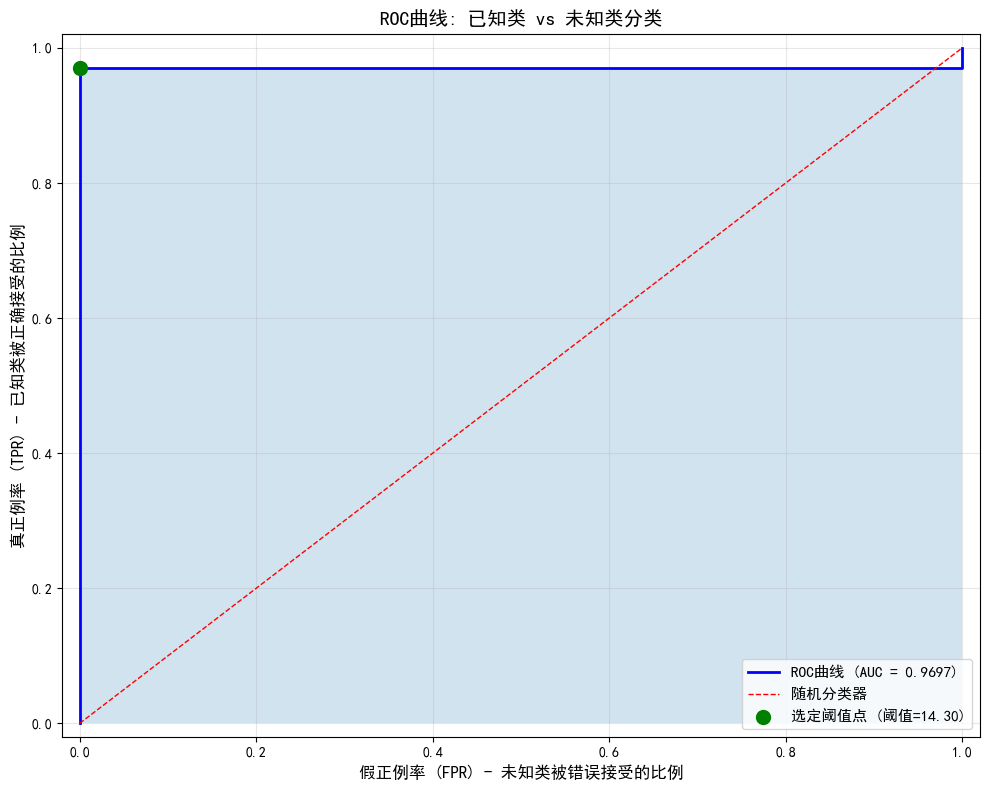

ROC曲线已保存为 roc_curve.png


In [20]:
# 绘制ROC曲线
plt.figure(figsize=(10, 8))

# 主ROC曲线
plt.plot(fpr, tpr, 'b-', linewidth=2, 
         label=f'ROC曲线 (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='随机分类器')

# 标记选定阈值对应的点
threshold_idx = np.argmin(np.abs(roc_thresholds - rejection_threshold))
plt.scatter(fpr[threshold_idx], tpr[threshold_idx], s=100, c='green', 
            zorder=5, label=f'选定阈值点 (阈值={rejection_threshold:.2f})')

plt.xlabel('假正例率 (FPR) - 未知类被错误接受的比例', fontsize=12)
plt.ylabel('真正例率 (TPR) - 已知类被正确接受的比例', fontsize=12)
plt.title('ROC曲线: 已知类 vs 未知类分类', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

# 填充AUC区域
plt.fill_between(fpr, tpr, alpha=0.2)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150)
plt.show()

print("ROC曲线已保存为 roc_curve.png")

## 10. 结果汇总

In [21]:
print("\n" + "="*60)
print("               SVM人脸识别拒识系统实验结果汇总")
print("="*60)

print("\n【数据集信息】")
print(f"  Yale数据集: 15个类别, {len(X_yale)}个样本")
print(f"  ORL数据集(外部): 40个类别, {len(X_orl_images)}个样本")
print(f"  特征维度: {X_train_scaled.shape[1]}")

print("\n【数据集划分】")
print(f"  训练集: {len(X_train)}个样本")
print(f"  验证集: {len(X_val)}个样本")
print(f"  测试集(已知类): {len(X_test_known)}个样本")
print(f"  测试集(未知类): {len(X_orl_scaled)}个样本")

print("\n【SVM模型参数】")
print(f"  最优参数: {grid_search.best_params_}")

print("\n【已知类测试集性能】")
print(f"  准确率 (Accuracy): {accuracy:.4f}")
print(f"  精确率 (Precision): {precision:.4f}")
print(f"  召回率 (Recall): {recall:.4f}")
print(f"  F1-score: {f1:.4f}")

print("\n【拒识系统性能】")
print(f"  拒识阈值: {rejection_threshold:.4f}")
print(f"  已知类召回率: {known_recall:.4f} (正确接受已知类的比例)")
print(f"  未知类拒绝率: {unknown_rejection:.4f} (正确拒绝未知类的比例)")
print(f"  AUC值: {roc_auc:.4f}")

print("\n【生成的图表】")
print("  1. confusion_matrix_known.png - 已知类混淆矩阵")
print("  2. confidence_distribution.png - 置信度分布")
print("  3. threshold_tradeoff.png - 阈值权衡曲线")
print("  4. roc_curve.png - ROC曲线")

print("\n" + "="*60)


               SVM人脸识别拒识系统实验结果汇总

【数据集信息】
  Yale数据集: 15个类别, 165个样本
  ORL数据集(外部): 40个类别, 400个样本
  特征维度: 4416

【数据集划分】
  训练集: 99个样本
  验证集: 33个样本
  测试集(已知类): 33个样本
  测试集(未知类): 400个样本

【SVM模型参数】
  最优参数: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

【已知类测试集性能】
  准确率 (Accuracy): 0.7879
  精确率 (Precision): 0.8157
  召回率 (Recall): 0.7879
  F1-score: 0.7830

【拒识系统性能】
  拒识阈值: 14.2955
  已知类召回率: 0.7879 (正确接受已知类的比例)
  未知类拒绝率: 1.0000 (正确拒绝未知类的比例)
  AUC值: 0.9697

【生成的图表】
  1. confusion_matrix_known.png - 已知类混淆矩阵
  2. confidence_distribution.png - 置信度分布
  3. threshold_tradeoff.png - 阈值权衡曲线
  4. roc_curve.png - ROC曲线

